In [24]:
import numpy as np 
import xarray as xr 
import MJO_E3SM_util as mjo
import pandas as pd 
import matplotlib.pyplot as plt 
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def get_comp_4(comp):
    comp5 = {}
    comp5['mse'] = comp['dse'] + comp['qlv']
    comp5['tendency'] = comp['dtdse'] + comp['dtqlv']
    comp5['crmpbl'] = comp['crm_dse'] + comp['crm_qlv'] + comp['pbl_dse'] + comp['pbl_qlv']
    comp5['dyn'] = comp['dyn_dse'] + comp['dyn_qlv']
    comp5['qr'] = comp['qr']

    return comp5

def get_comp_5_new(comp):
    comp8 = {}
    comp8['mse'] = comp['dse'] + comp['qlv']
    comp8['tendency'] = comp['dtdse'] + comp['dtqlv']
    comp8['tendency_d'] = comp['dtdse'] 
    comp8['tendency_m'] = comp['dtqlv']
    comp8['crmpbl_d'] = comp['crm_dse'] + comp['pbl_dse'] 
    comp8['crmpbl_m'] = comp['crm_qlv'] + comp['pbl_qlv']
    comp8['dyn_d'] = comp['dyn_dse'] 
    comp8['dyn_m'] = comp['dyn_qlv']
    comp8['qr'] = comp['qr']

    return comp8

In [26]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM_data/regridded_data/'
case_dir = 'control'
# case_dir = 'FIX_QRT'

In [27]:
develop_uncertainty = {}
develop_uncertainty['Tendency'] = []
develop_uncertainty['CRMPBL'] = []
develop_uncertainty['Radiation'] = []
develop_uncertainty['Dynamics'] = []

for lat_lim in [5, 10, 15]:
    for kmax in [7, 9, 11]:
        for Tlow in [90, 100, 110, 150]:
            for Thig in [10, 20, 30]:
                flg = str(lat_lim)+'_'+str(kmax)+'_'+str(Tlow)+'_'+str(Thig)
                com_fn = dirn+'analysis/local_MSE_budget/composite_local_MSE_budget_'+case_dir+flg+'.nc'  
                comp_tmp = xr.open_dataset(com_fn).sel(lat=slice(-lat_lim, lat_lim))
                comp = get_comp_4(comp_tmp)  # [lev, lat, lon]

                local_budget_develop = {}
                p = comp['mse']['lev']  # dataarray
                dp = np.zeros(len(p))
                dp[1:] = p[1:].values - p[0:-1].values
                dp[0] = dp[1]  # hPa

                dp = xr.DataArray(dp, dims='lev', coords={'lev': p})

                # integrate over pressure levels
                comp_int = {}

                for key in comp.keys():
                    comp_int[key] = (comp[key] * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

                for key in comp.keys():
                    local_budget_develop[key] = (comp_int['mse'] * comp_int[key]).mean(dim=['lon', 'lat'])  # domain average
                    
                norm = local_budget_develop['mse'] 
                develop_uncertainty['Tendency'].append(local_budget_develop['tendency'] / norm)
                develop_uncertainty['CRMPBL'].append(local_budget_develop['crmpbl'] / norm)
                develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                develop_uncertainty['Dynamics'].append(local_budget_develop['dyn'] / norm)

tend = develop_uncertainty['Tendency']
convd = develop_uncertainty['CRMPBL'] 
rad = develop_uncertainty['Radiation']
dynd = develop_uncertainty['Dynamics']

tend_av = np.mean(tend)
convd_av = np.mean(convd)
rad_av = np.mean(rad)
dynd_av = np.mean(dynd)

tend_std = np.std(tend)
convd_std = np.std(convd)
rad_std = np.std(rad)
dynd_std = np.std(dynd)

develop_mse = [tend_av, convd_av, rad_av, dynd_av]
develop_mse_std = [tend_std, convd_std, rad_std, dynd_std]  

x4 = ['Tendency', 'CRM+PBL', 'Radiation', 'Dynamics']
x_axis = np.arange(len(x4))



In [28]:
develop_uncertainty = {}
develop_uncertainty['Tendency_dry'] = []
develop_uncertainty['Tendency_moist'] = []
develop_uncertainty['CRMPBL_dry'] = []
develop_uncertainty['CRMPBL_moist'] = []
develop_uncertainty['Radiation'] = []
develop_uncertainty['Dynamics_dry'] = []
develop_uncertainty['Dynamics_moist'] = []

for lat_lim in [5, 10, 15]:
    for kmax in [7, 9, 11]:
        for Tlow in [90, 100, 110, 150]:
            for Thig in [10, 20, 30]:
                flg = str(lat_lim)+'_'+str(kmax)+'_'+str(Tlow)+'_'+str(Thig)
                com_fn = dirn+'analysis/local_MSE_budget/composite_local_MSE_budget_'+case_dir+flg+'.nc'  
                comp_tmp = xr.open_dataset(com_fn).sel(lat=slice(-lat_lim, lat_lim))
                comp = get_comp_5_new(comp_tmp)

                local_budget_develop = {}
                p = comp['mse']['lev']  # dataarray
                dp = np.zeros(len(p))
                dp[1:] = p[1:].values - p[0:-1].values
                dp[0] = dp[1]  # hPa

                dp = xr.DataArray(dp, dims='lev', coords={'lev': p})

                # integrate over pressure levels
                comp_int = {}

                for key in comp.keys():
                    comp_int[key] = (comp[key] * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

                for key in comp.keys():
                    local_budget_develop[key] = (comp_int['mse'] * comp_int[key]).mean(dim=['lon', 'lat'])  # domain average
           
                norm = local_budget_develop['mse'] 
                develop_uncertainty['Tendency_dry'].append(local_budget_develop['tendency_d'] / norm)
                develop_uncertainty['Tendency_moist'].append(local_budget_develop['tendency_m'] / norm)
                develop_uncertainty['CRMPBL_dry'].append(local_budget_develop['crmpbl_d'] / norm)
                develop_uncertainty['CRMPBL_moist'].append(local_budget_develop['crmpbl_m'] / norm)
                develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                develop_uncertainty['Dynamics_dry'].append(local_budget_develop['dyn_d'] / norm)
                develop_uncertainty['Dynamics_moist'].append(local_budget_develop['dyn_m'] / norm)

tendd = develop_uncertainty['Tendency_dry']
tendm = develop_uncertainty['Tendency_moist']
convd = develop_uncertainty['CRMPBL_dry'] 
convm = develop_uncertainty['CRMPBL_moist'] 
rad = develop_uncertainty['Radiation']
dynd = develop_uncertainty['Dynamics_dry']
dynm = develop_uncertainty['Dynamics_moist']

tendd_av = np.mean(tendd)
tendm_av = np.mean(tendm)
convd_av = np.mean(convd)
convm_av = np.mean(convm)
rad_av = np.mean(rad)
dynd_av = np.mean(dynd)
dynm_av = np.mean(dynm)

tendd_std = np.std(tendd)
tendm_std = np.std(tendm)
convd_std = np.std(convd)
convm_std = np.std(convm)
rad_std = np.std(rad)
dynd_std = np.std(dynd)
dynm_std = np.std(dynm)

develop_dse = [tendd_av, convd_av, rad_av, dynd_av]
develop_dse_std = [tendd_std, convd_std, rad_std, dynd_std]

develop_qlv = [tendm_av, convm_av, 0, dynm_av]
develop_qlv_std = [tendm_std, convm_std, 0, dynm_std]



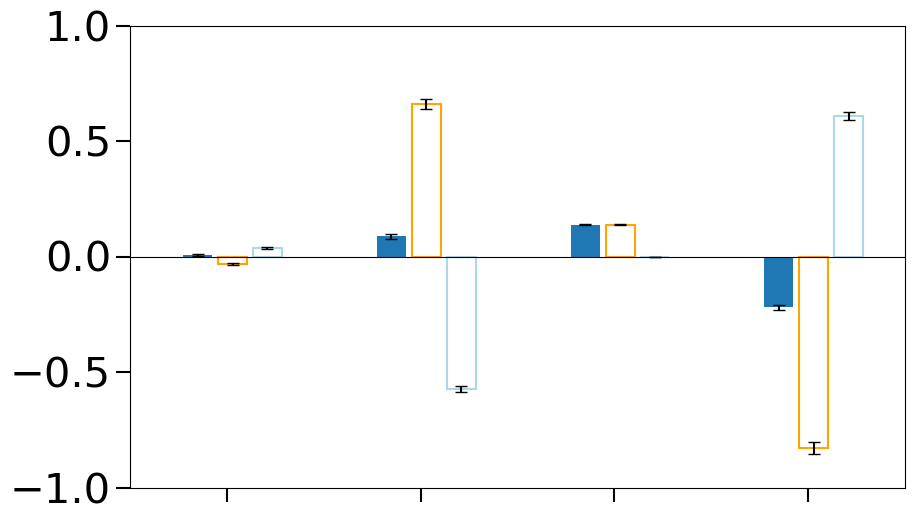

In [35]:
# Define the width of each bar and the spacing between bar groups
bar_width = 0.15
spacing = 0.03  # Space between bars within a group
group_width = (bar_width + spacing) * 2  # Width of each group of bars

fig, ax = plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 30})

# Adjust the position of each bar
for i in range(len(x_axis)):
    ax.bar(x_axis[i] - group_width / 2 + spacing, develop_mse[i], yerr=develop_mse_std[i], capsize=4, ecolor='black', width=bar_width, color='tab:blue')
    ax.bar(x_axis[i] - group_width / 2 + bar_width + 2 * spacing, develop_dse[i], yerr=develop_dse_std[i], capsize=4, ecolor='black', width=bar_width, color='white', edgecolor='orange', linewidth=1.5)
    ax.bar(x_axis[i] - group_width / 2 + 2 * bar_width + 3 * spacing, develop_qlv[i], yerr=develop_qlv_std[i], capsize=4, ecolor='black', width=bar_width, color='white', edgecolor='lightblue', linewidth=1.5)

ax.plot([-1,4],[0,0],'k-',linewidth=0.8)

ax.set_xticks(x_axis, ['','','',''])
# ax.set_ylabel("day" + r'$^{-1}$')
ax.set_ylim([-1.0,1.0])
ax.set_xlim([-0.5,3.5])
# ax.set_yticks([-0.5,-0.5,0,0.5,1])
ax.tick_params(axis='both', which='major', length=10, width=1.5)
plt.savefig('./plots/'+case_dir+'/VI_develop_4terms.pdf', bbox_inches='tight')

In [30]:
develop_uncertainty = {}
develop_uncertainty['Tendency'] = []
develop_uncertainty['CRMPBL'] = []
develop_uncertainty['Radiation'] = []
develop_uncertainty['Dynamics'] = []

for lat_lim in [5, 10, 15]:
    for kmax in [7, 9, 11]:
        for Tlow in [90, 100, 110, 150]:
            for Thig in [10, 20, 30]:
                flg = str(lat_lim)+'_'+str(kmax)+'_'+str(Tlow)+'_'+str(Thig)
                com_fn = dirn+'analysis/local_MSE_budget/composite_local_MSE_budget_'+case_dir+flg+'.nc'  
                comp_tmp = xr.open_dataset(com_fn).sel(lat=slice(-lat_lim, lat_lim))
                comp = get_comp_4(comp_tmp)

                local_budget_develop = {}
                p = comp['mse']['lev']  # dataarray
                dp = np.zeros(len(p))
                dp[1:] = p[1:].values - p[0:-1].values
                dp[0] = dp[1]  # hPa

                dp = xr.DataArray(dp, dims='lev', coords={'lev': p})

                # integrate over pressure levels
                comp_int = {}

                for key in comp.keys():
                    comp_int[key] = (comp[key] * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

                for key in comp.keys():
                    local_budget_develop[key] = (comp_int['tendency'] * comp_int[key]).mean(dim=['lon', 'lat'])  # domain average
           
                norm = local_budget_develop['tendency'] 
                develop_uncertainty['Tendency'].append(local_budget_develop['tendency'] / norm)
                develop_uncertainty['CRMPBL'].append(local_budget_develop['crmpbl'] / norm)
                develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                develop_uncertainty['Dynamics'].append(local_budget_develop['dyn'] / norm)

tend = develop_uncertainty['Tendency']
convd = develop_uncertainty['CRMPBL'] 
rad = develop_uncertainty['Radiation']
dynd = develop_uncertainty['Dynamics']

tend_av = np.mean(tend)
convd_av = np.mean(convd)
rad_av = np.mean(rad)
dynd_av = np.mean(dynd)

tend_std = np.std(tend)
convd_std = np.std(convd)
rad_std = np.std(rad)
dynd_std = np.std(dynd)

propagation_mse = [tend_av, convd_av, rad_av, dynd_av]
propagation_mse_std = [tend_std, convd_std, rad_std, dynd_std]  

x4 = ['Tendency', 'CRM+PBL', 'Radiation', 'Dynamics']
x_axis = np.arange(len(x4))



In [31]:
develop_uncertainty = {}
develop_uncertainty['Tendency_dry'] = []
develop_uncertainty['Tendency_moist'] = []
develop_uncertainty['CRMPBL_dry'] = []
develop_uncertainty['CRMPBL_moist'] = []
develop_uncertainty['Radiation'] = []
develop_uncertainty['Dynamics_dry'] = []
develop_uncertainty['Dynamics_moist'] = []

for lat_lim in [5, 10, 15]:
    for kmax in [7, 9, 11]:
        for Tlow in [90, 100, 110, 150]:
            for Thig in [10, 20, 30]:
                flg = str(lat_lim)+'_'+str(kmax)+'_'+str(Tlow)+'_'+str(Thig)
                com_fn = dirn+'analysis/local_MSE_budget/composite_local_MSE_budget_'+case_dir+flg+'.nc'  
                comp_tmp = xr.open_dataset(com_fn).sel(lat=slice(-lat_lim, lat_lim))
                comp = get_comp_5_new(comp_tmp)

                local_budget_develop = {}
                p = comp['mse']['lev']  # dataarray
                dp = np.zeros(len(p))
                dp[1:] = p[1:].values - p[0:-1].values
                dp[0] = dp[1]  # hPa

                dp = xr.DataArray(dp, dims='lev', coords={'lev': p})

                # integrate over pressure levels
                comp_int = {}

                for key in comp.keys():
                    comp_int[key] = (comp[key] * dp / 9.8 * 100).sum(dim='lev') # [lat, lon]

                for key in comp.keys():
                    local_budget_develop[key] = (comp_int['tendency'] * comp_int[key]).mean(dim=['lon', 'lat'])  # domain average
           
                norm = local_budget_develop['tendency'] 
                develop_uncertainty['Tendency_dry'].append(local_budget_develop['tendency_d'] / norm)
                develop_uncertainty['Tendency_moist'].append(local_budget_develop['tendency_m'] / norm)
                develop_uncertainty['CRMPBL_dry'].append(local_budget_develop['crmpbl_d'] / norm)
                develop_uncertainty['CRMPBL_moist'].append(local_budget_develop['crmpbl_m'] / norm)
                develop_uncertainty['Radiation'].append(local_budget_develop['qr'] / norm) 
                develop_uncertainty['Dynamics_dry'].append(local_budget_develop['dyn_d'] / norm)
                develop_uncertainty['Dynamics_moist'].append(local_budget_develop['dyn_m'] / norm)

tendd = develop_uncertainty['Tendency_dry']
tendm = develop_uncertainty['Tendency_moist']
convd = develop_uncertainty['CRMPBL_dry'] 
convm = develop_uncertainty['CRMPBL_moist'] 
rad = develop_uncertainty['Radiation']
dynd = develop_uncertainty['Dynamics_dry']
dynm = develop_uncertainty['Dynamics_moist']

tendd_av = np.mean(tendd)
tendm_av = np.mean(tendm)
convd_av = np.mean(convd)
convm_av = np.mean(convm)
rad_av = np.mean(rad)
dynd_av = np.mean(dynd)
dynm_av = np.mean(dynm)

tendd_std = np.std(tendd)
tendm_std = np.std(tendm)
convd_std = np.std(convd)
convm_std = np.std(convm)
rad_std = np.std(rad)
dynd_std = np.std(dynd)
dynm_std = np.std(dynm)

propagation_dse = [tendd_av, convd_av, rad_av, dynd_av]
propagation_dse_std = [tendd_std, convd_std, rad_std, dynd_std]

propagation_qlv = [tendm_av, convm_av, 0, dynm_av]
propagation_qlv_std = [tendm_std, convm_std, 0, dynm_std]



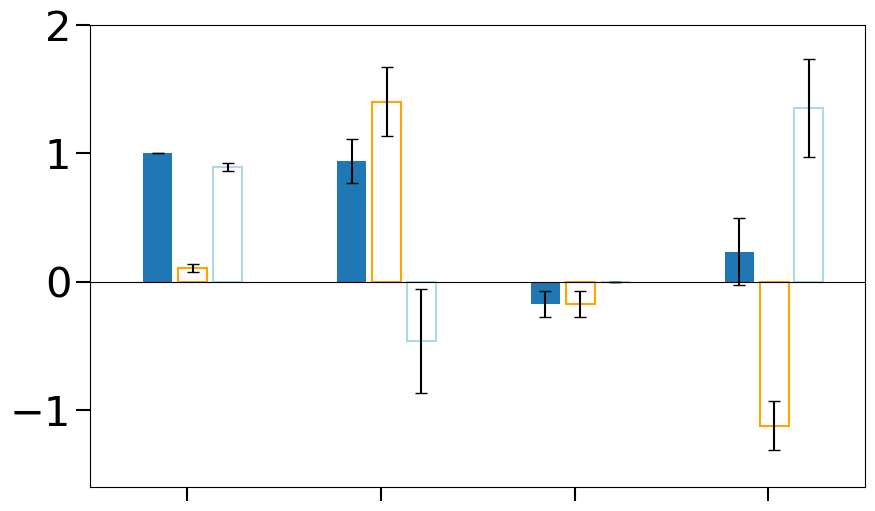

In [36]:
# Define the width of each bar and the spacing between bar groups
bar_width = 0.15
spacing = 0.03  # Space between bars within a group
group_width = (bar_width + spacing) * 2  # Width of each group of bars

fig, ax = plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 30})

# Adjust the position of each bar
for i in range(len(x_axis)):
    ax.bar(x_axis[i] - group_width / 2 + spacing, propagation_mse[i], yerr=propagation_mse_std[i], capsize=4, ecolor='black', width=bar_width, color='tab:blue')
    ax.bar(x_axis[i] - group_width / 2 + bar_width + 2 * spacing, propagation_dse[i], yerr=propagation_dse_std[i], capsize=4, ecolor='black', width=bar_width, color='white', edgecolor='orange', linewidth=1.5)
    ax.bar(x_axis[i] - group_width / 2 + 2 * bar_width + 3 * spacing, propagation_qlv[i], yerr=propagation_qlv_std[i], capsize=4, ecolor='black', width=bar_width, color='white', edgecolor='lightblue', linewidth=1.5)

ax.plot([-1,4],[0,0],'k-',linewidth=0.8)
ax.tick_params(axis='both', which='major', length=10, width=1.5)
ax.set_xticks(x_axis, ['','','',''])
# ax.set_ylabel("day" + r'$^{-1}$')
ax.set_ylim([-1.6,2.0])
ax.set_xlim([-0.5,3.5])
# ax.set_yticks([-1.5,-1,-0.5,0,0.5,1,1.5])
plt.savefig('./plots/'+case_dir+'/VI_propagation_4terms.pdf', bbox_inches='tight')